### Load Library

In [1]:
import pandas as pd
from datasets import load_dataset

import string
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np

from string import punctuation, ascii_lowercase, digits


import re
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

from datasets import load_dataset
from sklearn.model_selection import train_test_split


import fasttext
import tempfile
import os

from sklearn.metrics import classification_report
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pickle


### Import Dataset

In [2]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")

train = dataset['train'].to_pandas()
train = train.drop(columns='id')

In [3]:
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

### Data Wrangling

#### Remove URLs from texts

In [4]:
@lru_cache(maxsize=200000)  # Cache results for frequent texts
def preprocess_text(text):
    """
    Preprocess text by removing URLs.
    """
    url_pattern = r'(?:https?:\/\/)?(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)'

    url_pattern = re.compile(url_pattern)

    return url_pattern.sub('', text)

# For processing the entire dataset at once
def batch_preprocess(texts, batch_size=20000):
    """
    Process texts in batches using parallel processing.
    """
    from concurrent.futures import ThreadPoolExecutor
    import numpy as np
    
    # Split texts into batches
    batches = np.array_split(texts, len(texts) // batch_size + 1)
    
    # Process batches in parallel
    with ThreadPoolExecutor() as executor:
        processed_batches = list(executor.map(
            lambda batch: [preprocess_text(text) for text in batch],
            batches
        ))
    
    # Flatten results
    return [text for batch in processed_batches for text in batch]


In [5]:
train.question_title = batch_preprocess(train.question_title.values)
train.question_content = batch_preprocess(train.question_content.values)
train.best_answer = batch_preprocess(train.best_answer.values)

#### Remove special characters and punctuations

In [6]:
punctuation = set(string.punctuation)
# get rid of special characters
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 '
stopwordsSet = set(stopwords.words("english"))

def clean_text(content):
    content = content.lower()
    content = ''.join([c for c in content if c not in punctuation and c in alphabet])
    content = ' '.join(w for w in content.split() if w not in stopwordsSet)
    return content

In [7]:
train.question_title = train.question_title.apply(lambda x: clean_text(x))
train.question_content = train.question_content.apply(lambda x: clean_text(x))
train.best_answer = train.best_answer.apply(lambda x: clean_text(x))

In [8]:
# # Example of website rows
# # pd.set_option('display.max_colwidth', None)
# selected_rows = train.iloc[6:8]
# selected_rows

In [9]:
# # Example of mathmatical formula rows
# selected_math_rows = train.iloc[15:16]
# selected_math_rows[['best_answer']]

In [10]:
train

,topic,question_title,question_content,best_answer,topic_name
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...,Computers & Internet
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online,Sports
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...,Health
3,6,many planes fedex,heard largest airline world,according web sitenair fleetbr n br n670 aircr...,Business & Finance
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...,Business & Finance
...,...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...,Health
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets,Business & Finance
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...,Health
1399998,0,speak hindi,write,main hindi bol sakti,Society & Culture


### Visualize frequent words

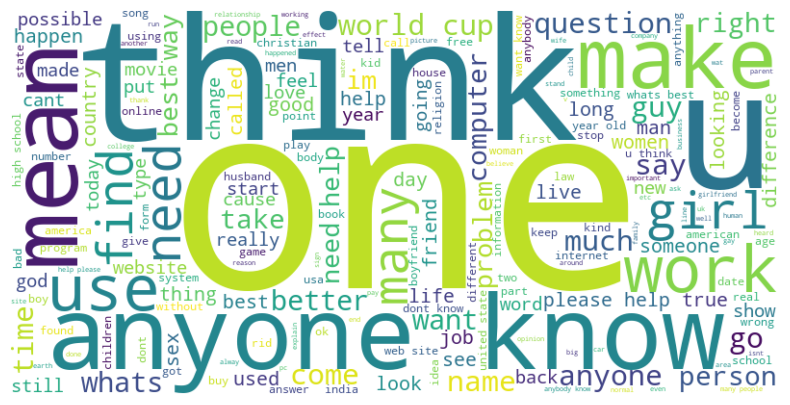

In [11]:
# # Words in question title
# question_titles = " ".join(s for s in train.question_title)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

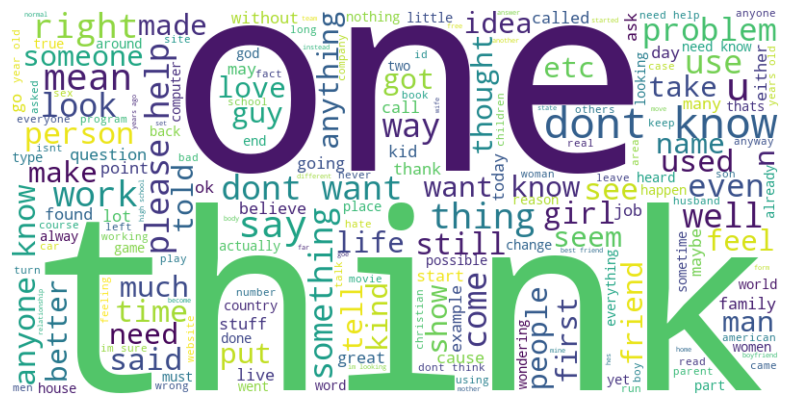

In [ ]:
# # Words in question content
# question_contents = " ".join(s for s in train.question_content)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

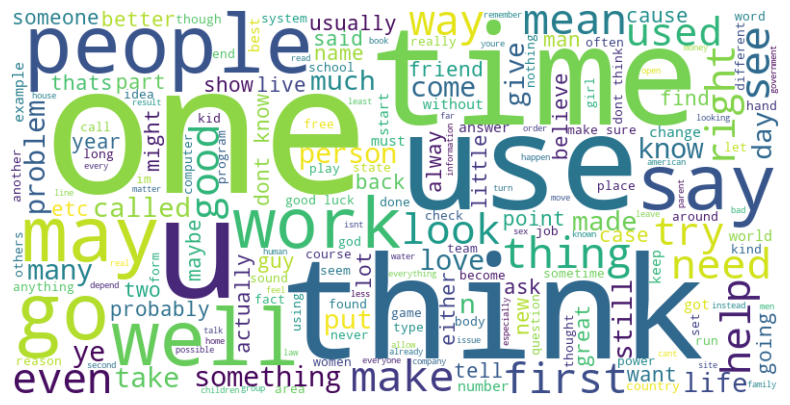

In [ ]:
# # Sample 20% of the words in answers
# sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [12]:
# check number of records for each topic
topic_counts = train['topic_name'].value_counts()
topic_counts

topic_name
Computers & Internet      140000
Sports                    140000
Health                    140000
Business & Finance        140000
Science & Mathematics     140000
Entertainment & Music     140000
Education & Reference     140000
Family & Relationships    140000
Politics & Government     140000
Society & Culture         140000
Name: count, dtype: int64

### Check Empty Values and Combine Columns

In [13]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        5069
question_content    637878
best_answer          42550
topic_name               0
dtype: int64

In [14]:
# Combine Question title and question content together
combine = train.copy()
combine['question'] = combine['question_title'] + ' ' + combine['question_content']
combine = combine.drop(columns=['question_title', 'question_content'])

In [15]:
combine

,topic,best_answer,topic_name,question
0,4,optical mice use led camera rapidly capture im...,Computers & Internet,doesnt optical mouse work glass table even sur...
1,5,hear mojave road amazingbr nsearch online,Sports,best offroad motorcycle trail longdistance tra...
2,2,trans fats occur manufactured foods process pa...,Health,trans fat reduce heard tras fat bad body find ...
3,6,according web sitenair fleetbr n br n670 aircr...,Business & Finance,many planes fedex heard largest airline world
4,6,renting vs buying depends goals br ngenerally ...,Business & Finance,san francisco bay area make sense rent buy pri...
...,...,...,...,...
1399995,2,increased height 2 feet afterwards yesnnof cou...,Health,ads tv yoko etc regarding height increase use
1399996,6,ebay electronic boutique babbages flea markets,Business & Finance,ways sell video games like want sell video gam...
1399997,2,normal long cancerous breasts examined every 6...,Health,normal nots breast boobs
1399998,0,main hindi bol sakti,Society & Culture,speak hindi write


In [16]:
combine.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = combine.isna().sum()
nan_counts

topic              0
best_answer    42550
topic_name         0
question         625
dtype: int64

In [17]:
# drop all NaNs from train dataset
train_clean = combine.dropna()
train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_clean.isna().sum()
nan_counts

/var/folders/cg/x0x5fs4j01d2vgcbqlxq3m1c0000gn/T/ipykernel_13953/2553255681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)


topic          0
best_answer    0
topic_name     0
question       0
dtype: int64

In [18]:
train_clean.shape

(1356901, 4)

### Check Duplicates

In [19]:
duplicate_count = train_clean.duplicated(subset=['topic', 'question', 'best_answer']).sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 301


In [20]:
# drop duplicates
train_clean_no_duplicates = train_clean.drop_duplicates(subset=['topic', 'question', 'best_answer']).reset_index(drop=True)

In [21]:
len(train_clean_no_duplicates)

1356600

In [22]:
# check number of records for each topic
topic_counts = train_clean_no_duplicates['topic_name'].value_counts()
topic_counts = pd.DataFrame(topic_counts)

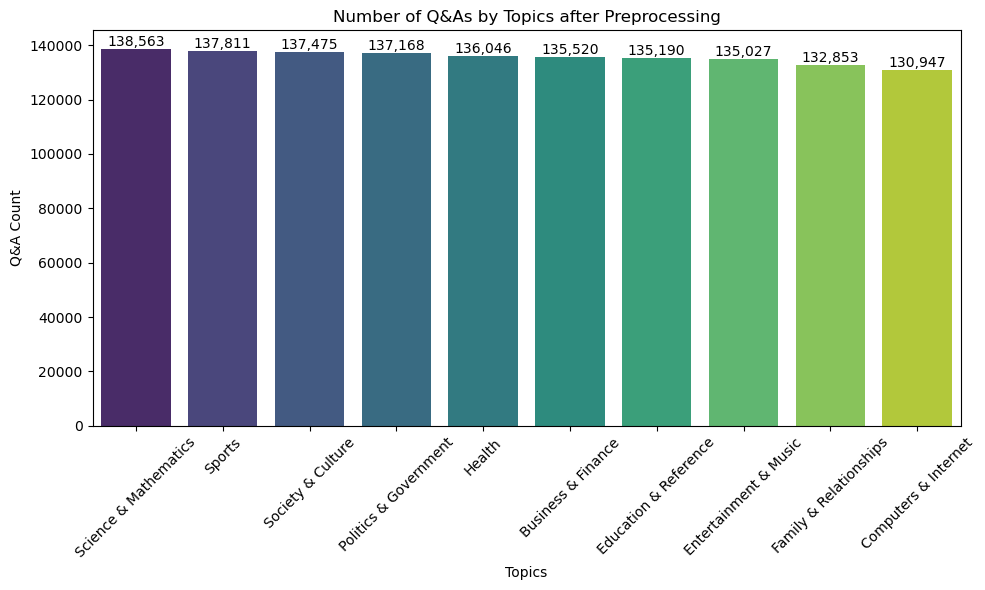

In [23]:
# Plotting the total count of MAC addresses per level
plt.figure(figsize=(10, 6))
sns.barplot(x='topic_name', y='count', hue='topic_name', data=topic_counts, palette='viridis')

plt.xlabel('Topics')
plt.ylabel('Q&A Count')
plt.title('Number of Q&As by Topics after Preprocessing')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(topic_counts['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Train test split

In [24]:
X = train_clean_no_duplicates.drop(columns=['topic', 'topic_name'])
y = train_clean_no_duplicates['topic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
len(X_train)

1085280

In [26]:
len(y_train)

1085280

In [27]:
len(X_val)

271320

In [28]:
len(y_val)

271320

In [29]:
X_train.head()

,best_answer,question
797700,would hear know good rap studio sessions write...,class got bored made lil freestyle readin word...
1074792,tennis balls diameter two half inches two five...,diameter tennis ball golf ball someone tell di...
1082458,air naturally comes high pressure fronts low p...,question wind wind come
294723,practice playing pick games people whenever ru...,tips better soccer player
100598,quite think general international policy unite...,nonamericans many think bush war criminal hear...


In [30]:
X_val.head()

,best_answer,question
803517,200 years ago scottish historian alexander tyl...,limited government become contradiction terms ...
379914,havent met since last year,informations meeting bishop fellay society st ...
594208,yes however dont medical records doctor posses...,doctor texas charge another doctor medical rec...
43537,try following websites one irs publications ev...,need list someone selfemployed husband selfemp...
1348297,certain extend would interested anything besid...,penis become smaller man become older


In [31]:
# # Save the variables
# with open('split_data_v2.pkl', 'wb') as f:
#     pickle.dump((X_train, X_val, y_train, y_val), f)

In [32]:
# Load the variables
with open('split_data_v2.pkl', 'rb') as f:
    X_train, X_val, y_train, y_val = pickle.load(f)

### FastText Classification


In [34]:
train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_combined = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)

In [35]:
print(len(train_combined))
print(len(val_combined))

1085280
271320


In [36]:
train_combined['category'] = "__label__" + train_combined['topic'].astype(str)
val_combined['category'] = "__label__" + val_combined['topic'].astype(str)


#### FastText Classification using question

In [37]:
train_combined['category_question'] = train_combined['category'] + " " + train_combined['question']
train_combined

,best_answer,question,topic,category,category_question
0,would hear know good rap studio sessions write...,class got bored made lil freestyle readin word...,7,__label__7,__label__7 class got bored made lil freestyle ...
1,tennis balls diameter two half inches two five...,diameter tennis ball golf ball someone tell di...,1,__label__1,__label__1 diameter tennis ball golf ball some...
2,air naturally comes high pressure fronts low p...,question wind wind come,1,__label__1,__label__1 question wind wind come
3,practice playing pick games people whenever ru...,tips better soccer player,5,__label__5,__label__5 tips better soccer player
4,quite think general international policy unite...,nonamericans many think bush war criminal hear...,9,__label__9,__label__9 nonamericans many think bush war cr...
...,...,...,...,...,...
1085275,country needs read constitutionnnnearly everyt...,us get new constitution old constitution prohi...,9,__label__9,__label__9 us get new constitution old constit...
1085276,everything need know zinc nitrate,zinc nitrate need information zinc nitrate,1,__label__1,__label__1 zinc nitrate need information zinc ...
1085277,limestone formation 101nn1 ocean organisms con...,limestone formed,1,__label__1,__label__1 limestone formed
1085278,job support child house atleast two bedrooms g...,get custody back child,6,__label__6,__label__6 get custody back child


In [38]:
val_combined['category_question'] = val_combined['category'] + " " + val_combined['question']
val_combined

,best_answer,question,topic,category,category_question
0,200 years ago scottish historian alexander tyl...,limited government become contradiction terms ...,9,__label__9,__label__9 limited government become contradic...
1,havent met since last year,informations meeting bishop fellay society st ...,0,__label__0,__label__0 informations meeting bishop fellay ...
2,yes however dont medical records doctor posses...,doctor texas charge another doctor medical rec...,2,__label__2,__label__2 doctor texas charge another doctor ...
3,try following websites one irs publications ev...,need list someone selfemployed husband selfemp...,6,__label__6,__label__6 need list someone selfemployed husb...
4,certain extend would interested anything besid...,penis become smaller man become older,2,__label__2,__label__2 penis become smaller man become older
...,...,...,...,...,...
271315,ans 4 higher electric potentialnna positive ch...,realease electron rest presence electric field...,1,__label__1,__label__1 realease electron rest presence ele...
271316,previous responder brings excellent points par...,method gravimetric analysis volumetric analysi...,1,__label__1,__label__1 method gravimetric analysis volumet...
271317,dumb idiota nfaggetmaricn nwhippedmandilnnnsom...,anyone tell cruse words spanish want learn dum...,0,__label__0,__label__0 anyone tell cruse words spanish wan...
271318,lol clip,true always lift heavy equipment pennis become...,2,__label__2,__label__2 true always lift heavy equipment pe...


In [39]:
# save train and validation into txt format
train_combined.to_csv("FastText_question.train",columns=["category_question"],index=False,header=False)
val_combined.to_csv("FastText_question.val",columns=["category_question"],index=False,header=False)


In [40]:
# train fasttext classification model
question_model = fasttext.train_supervised(input="FastText_question.train")
question_model.test("FastText_question.val")

Read 19M words
Number of words:  682187
Number of labels: 10
Progress: 100.0% words/sec/thread: 3566408 lr:  0.000000 avg.loss:  1.011833 ETA:   0h 0m 0s


(271320, 0.7012605042016806, 0.7012605042016806)

In [41]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_question.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [question_model.predict(text)[0][0] for text in validation_data]

In [42]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7012605042016806
Macro Precision: 0.6982331029177977
Macro Recall: 0.7016306024050782
Macro F1-score: 0.6993208787259885


In [ ]:
# # Define parameter options
# parameter_options = {
#     "epoch": [5, 10, 15],
#     "lr": [0.1, 0.3, 0.5],
#     "wordNgrams": [1, 2],
#     "dim": [100, 200],
#     "loss": ["softmax", "ova"]
# }


In [ ]:
# # Generate all combinations of parameters
# parameter_combinations = list(itertools.product(
#     parameter_options["epoch"],
#     parameter_options["lr"],
#     parameter_options["wordNgrams"],
#     parameter_options["dim"],
#     parameter_options["loss"]
# ))

In [ ]:
# results = []

# for params in parameter_combinations:
#     epoch, lr, wordNgrams, dim, loss = params

#     model = fasttext.train_supervised(
#         input="FastText_all.train",
#         epoch=epoch,
#         lr=lr,
#         wordNgrams=wordNgrams,
#         dim=dim,
#         loss=loss
#     )

#     # Predict on validation data
#     predicted_labels = [model.predict(text)[0][0] for text in validation_data]

#     # Compute metrics
#     report = classification_report(true_labels, predicted_labels, output_dict=True)
#     accuracy = report["accuracy"]
#     macro_precision = report["macro avg"]["precision"]
#     macro_recall = report["macro avg"]["recall"]
#     macro_f1 = report["macro avg"]["f1-score"]

#     # Store results
#     results.append({
#         "epoch": epoch,
#         "lr": lr,
#         "wordNgrams": wordNgrams,
#         "dim": dim,
#         "loss": loss,
#         "accuracy": accuracy,
#         "macro_precision": macro_precision,
#         "macro_recall": macro_recall,
#         "macro_f1": macro_f1
#     })

#     print(f"Completed combination: {params}")

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="macro_f1", ascending=False)

In [ ]:
# results_df

#### FastText Classification using best_answer

In [43]:
train_combined['category_best_answer'] = train_combined['category'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,would hear know good rap studio sessions write...,class got bored made lil freestyle readin word...,7,__label__7,__label__7 class got bored made lil freestyle ...,__label__7 would hear know good rap studio ses...
1,tennis balls diameter two half inches two five...,diameter tennis ball golf ball someone tell di...,1,__label__1,__label__1 diameter tennis ball golf ball some...,__label__1 tennis balls diameter two half inch...
2,air naturally comes high pressure fronts low p...,question wind wind come,1,__label__1,__label__1 question wind wind come,__label__1 air naturally comes high pressure f...
3,practice playing pick games people whenever ru...,tips better soccer player,5,__label__5,__label__5 tips better soccer player,__label__5 practice playing pick games people ...
4,quite think general international policy unite...,nonamericans many think bush war criminal hear...,9,__label__9,__label__9 nonamericans many think bush war cr...,__label__9 quite think general international p...
...,...,...,...,...,...,...
1085275,country needs read constitutionnnnearly everyt...,us get new constitution old constitution prohi...,9,__label__9,__label__9 us get new constitution old constit...,__label__9 country needs read constitutionnnne...
1085276,everything need know zinc nitrate,zinc nitrate need information zinc nitrate,1,__label__1,__label__1 zinc nitrate need information zinc ...,__label__1 everything need know zinc nitrate
1085277,limestone formation 101nn1 ocean organisms con...,limestone formed,1,__label__1,__label__1 limestone formed,__label__1 limestone formation 101nn1 ocean or...
1085278,job support child house atleast two bedrooms g...,get custody back child,6,__label__6,__label__6 get custody back child,__label__6 job support child house atleast two...


In [44]:
val_combined['category_best_answer'] = val_combined['category'] + " " + val_combined['best_answer']
val_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,200 years ago scottish historian alexander tyl...,limited government become contradiction terms ...,9,__label__9,__label__9 limited government become contradic...,__label__9 200 years ago scottish historian al...
1,havent met since last year,informations meeting bishop fellay society st ...,0,__label__0,__label__0 informations meeting bishop fellay ...,__label__0 havent met since last year
2,yes however dont medical records doctor posses...,doctor texas charge another doctor medical rec...,2,__label__2,__label__2 doctor texas charge another doctor ...,__label__2 yes however dont medical records do...
3,try following websites one irs publications ev...,need list someone selfemployed husband selfemp...,6,__label__6,__label__6 need list someone selfemployed husb...,__label__6 try following websites one irs publ...
4,certain extend would interested anything besid...,penis become smaller man become older,2,__label__2,__label__2 penis become smaller man become older,__label__2 certain extend would interested any...
...,...,...,...,...,...,...
271315,ans 4 higher electric potentialnna positive ch...,realease electron rest presence electric field...,1,__label__1,__label__1 realease electron rest presence ele...,__label__1 ans 4 higher electric potentialnna ...
271316,previous responder brings excellent points par...,method gravimetric analysis volumetric analysi...,1,__label__1,__label__1 method gravimetric analysis volumet...,__label__1 previous responder brings excellent...
271317,dumb idiota nfaggetmaricn nwhippedmandilnnnsom...,anyone tell cruse words spanish want learn dum...,0,__label__0,__label__0 anyone tell cruse words spanish wan...,__label__0 dumb idiota nfaggetmaricn nwhippedm...
271318,lol clip,true always lift heavy equipment pennis become...,2,__label__2,__label__2 true always lift heavy equipment pe...,__label__2 lol clip


In [45]:
# save train and validation into txt format
train_combined.to_csv("FastText_best_answer.train",columns=["category_best_answer"],index=False,header=False)
val_combined.to_csv("FastText_best_answer.val",columns=["category_best_answer"],index=False,header=False)


In [46]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_best_answer.train")
best_answer_model.test("FastText_best_answer.val")

Read 36M words
Number of words:  1479061
Number of labels: 10
Progress: 100.0% words/sec/thread: 4287353 lr:  0.000000 avg.loss:  1.340128 ETA:   0h 0m 0s


(271320, 0.6000073713696005, 0.6000073713696005)

In [47]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_best_answer.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [48]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.6000073713696005
Macro Precision: 0.5973686431190421
Macro Recall: 0.6003979395152217
Macro F1-score: 0.597413885646633


#### FastText Classification using best_answer and question

In [49]:
train_combined['category_all'] = train_combined['category'] + " " + train_combined['question'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,would hear know good rap studio sessions write...,class got bored made lil freestyle readin word...,7,__label__7,__label__7 class got bored made lil freestyle ...,__label__7 would hear know good rap studio ses...,__label__7 class got bored made lil freestyle ...
1,tennis balls diameter two half inches two five...,diameter tennis ball golf ball someone tell di...,1,__label__1,__label__1 diameter tennis ball golf ball some...,__label__1 tennis balls diameter two half inch...,__label__1 diameter tennis ball golf ball some...
2,air naturally comes high pressure fronts low p...,question wind wind come,1,__label__1,__label__1 question wind wind come,__label__1 air naturally comes high pressure f...,__label__1 question wind wind come air natural...
3,practice playing pick games people whenever ru...,tips better soccer player,5,__label__5,__label__5 tips better soccer player,__label__5 practice playing pick games people ...,__label__5 tips better soccer player practice...
4,quite think general international policy unite...,nonamericans many think bush war criminal hear...,9,__label__9,__label__9 nonamericans many think bush war cr...,__label__9 quite think general international p...,__label__9 nonamericans many think bush war cr...
...,...,...,...,...,...,...,...
1085275,country needs read constitutionnnnearly everyt...,us get new constitution old constitution prohi...,9,__label__9,__label__9 us get new constitution old constit...,__label__9 country needs read constitutionnnne...,__label__9 us get new constitution old constit...
1085276,everything need know zinc nitrate,zinc nitrate need information zinc nitrate,1,__label__1,__label__1 zinc nitrate need information zinc ...,__label__1 everything need know zinc nitrate,__label__1 zinc nitrate need information zinc ...
1085277,limestone formation 101nn1 ocean organisms con...,limestone formed,1,__label__1,__label__1 limestone formed,__label__1 limestone formation 101nn1 ocean or...,__label__1 limestone formed limestone formati...
1085278,job support child house atleast two bedrooms g...,get custody back child,6,__label__6,__label__6 get custody back child,__label__6 job support child house atleast two...,__label__6 get custody back child job support...


In [50]:
val_combined['category_all'] = val_combined['category'] + " " + val_combined['question'] + " " + val_combined['best_answer']

val_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,200 years ago scottish historian alexander tyl...,limited government become contradiction terms ...,9,__label__9,__label__9 limited government become contradic...,__label__9 200 years ago scottish historian al...,__label__9 limited government become contradic...
1,havent met since last year,informations meeting bishop fellay society st ...,0,__label__0,__label__0 informations meeting bishop fellay ...,__label__0 havent met since last year,__label__0 informations meeting bishop fellay ...
2,yes however dont medical records doctor posses...,doctor texas charge another doctor medical rec...,2,__label__2,__label__2 doctor texas charge another doctor ...,__label__2 yes however dont medical records do...,__label__2 doctor texas charge another doctor ...
3,try following websites one irs publications ev...,need list someone selfemployed husband selfemp...,6,__label__6,__label__6 need list someone selfemployed husb...,__label__6 try following websites one irs publ...,__label__6 need list someone selfemployed husb...
4,certain extend would interested anything besid...,penis become smaller man become older,2,__label__2,__label__2 penis become smaller man become older,__label__2 certain extend would interested any...,__label__2 penis become smaller man become old...
...,...,...,...,...,...,...,...
271315,ans 4 higher electric potentialnna positive ch...,realease electron rest presence electric field...,1,__label__1,__label__1 realease electron rest presence ele...,__label__1 ans 4 higher electric potentialnna ...,__label__1 realease electron rest presence ele...
271316,previous responder brings excellent points par...,method gravimetric analysis volumetric analysi...,1,__label__1,__label__1 method gravimetric analysis volumet...,__label__1 previous responder brings excellent...,__label__1 method gravimetric analysis volumet...
271317,dumb idiota nfaggetmaricn nwhippedmandilnnnsom...,anyone tell cruse words spanish want learn dum...,0,__label__0,__label__0 anyone tell cruse words spanish wan...,__label__0 dumb idiota nfaggetmaricn nwhippedm...,__label__0 anyone tell cruse words spanish wan...
271318,lol clip,true always lift heavy equipment pennis become...,2,__label__2,__label__2 true always lift heavy equipment pe...,__label__2 lol clip,__label__2 true always lift heavy equipment pe...


In [51]:
# save train and validation into txt format
train_combined.to_csv("FastText_all.train",columns=["category_all"],index=False,header=False)
val_combined.to_csv("FastText_all.val",columns=["category_all"],index=False,header=False)


In [52]:
# train fasttext classification model
all_model = fasttext.train_supervised(input="FastText_all.train")
all_model.test("FastText_all.val")

Read 54M words
Number of words:  1906251
Number of labels: 10
Progress: 100.0% words/sec/thread: 5282175 lr:  0.000000 avg.loss:  0.959618 ETA:   0h 0m 0s 0.959618 ETA:   0h 0m 0s


(271320, 0.7130252100840336, 0.7130252100840336)

In [53]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_all.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [all_model.predict(text)[0][0] for text in validation_data]

In [54]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7130252100840336
Macro Precision: 0.7092958845982033
Macro Recall: 0.7132949089431915
Macro F1-score: 0.7104652152586493


In [55]:
with open("FastText_all.val", "r") as f:
    lines = f.readlines()

true_labels = []
predicted_labels = []

for line in lines:
    label, text = line.split(" ", 1)
    true_labels.append(label)
    predicted_labels.append(all_model.predict(text.strip())[0][0])
print(classification_report(true_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

  __label__0     0.5971    0.5870    0.5920     27495
  __label__1     0.7147    0.7534    0.7335     27713
  __label__2     0.7654    0.7984    0.7816     27209
  __label__3     0.5687    0.5000    0.5321     27038
  __label__4     0.8399    0.8599    0.8498     26189
  __label__5     0.8837    0.8842    0.8839     27562
  __label__6     0.5770    0.5045    0.5383     27104
  __label__7     0.7011    0.7085    0.7048     27005
  __label__8     0.6863    0.7738    0.7274     26571
  __label__9     0.7590    0.7632    0.7611     27434

    accuracy                         0.7130    271320
   macro avg     0.7093    0.7133    0.7105    271320
weighted avg     0.7092    0.7130    0.7103    271320



In [57]:
# train fasttext classification model
all_model_param = fasttext.train_supervised(input='FastText_all.train', 
                                      epoch=2, 
                                      lr=0.3, 
                                      wordNgrams=2, 
                                      dim=300,
                                      minn=3,                 # Minimum character n-gram size
                                      maxn=6,                 # Maximum character n-gram size
                                      bucket=5000000,         # Large hash bucket size
                                      loss='softmax')
all_model_param.test("FastText_all.val")

Read 54M words
Number of words:  1906251
Number of labels: 10
Progress: 100.0% words/sec/thread:   64370 lr:  0.000000 avg.loss:  1.062218 ETA:   0h 0m 0s  5.1% words/sec/thread:   27975 lr:  0.284828 avg.loss:  1.696329 ETA:   0h 8m46s% words/sec/thread:   34658 lr:  0.252402 avg.loss:  1.332911 ETA:   0h 6m16s 25.6% words/sec/thread:   40787 lr:  0.223055 avg.loss:  1.242190 ETA:   0h 4m42s  40702 lr:  0.223035 avg.loss:  1.242323 ETA:   0h 4m43s 34.4% words/sec/thread:   43828 lr:  0.196920 avg.loss:  1.205499 ETA:   0h 3m52s 51.8% words/sec/thread:   47949 lr:  0.144669 avg.loss:  1.156948 ETA:   0h 2m35s 67.0% words/sec/thread:   54938 lr:  0.099002 avg.loss:  1.110716 ETA:   0h 1m33s 67.2% words/sec/thread:   54701 lr:  0.098541 avg.loss:  1.110432 ETA:   0h 1m33s 77.9% words/sec/thread:   58824 lr:  0.066266 avg.loss:  1.089715 ETA:   0h 0m58s 86.7% words/sec/thread:   61493 lr:  0.039751 avg.loss:  1.076306 ETA:   0h 0m33s


(271320, 0.7149307091257555, 0.7149307091257555)

In [58]:
with open("FastText_all.val", "r") as f:
    lines = f.readlines()

true_labels = []
predicted_labels = []

for line in lines:
    label, text = line.split(" ", 1)
    true_labels.append(label)
    predicted_labels.append(all_model_param.predict(text.strip())[0][0])
print(classification_report(true_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

  __label__0     0.5969    0.5863    0.5916     27495
  __label__1     0.7165    0.7608    0.7380     27713
  __label__2     0.7633    0.8066    0.7844     27209
  __label__3     0.5735    0.4969    0.5324     27038
  __label__4     0.8384    0.8650    0.8515     26189
  __label__5     0.8777    0.8821    0.8799     27562
  __label__6     0.5905    0.4993    0.5411     27104
  __label__7     0.6964    0.7134    0.7048     27005
  __label__8     0.6977    0.7682    0.7312     26571
  __label__9     0.7536    0.7732    0.7633     27434

    accuracy                         0.7149    271320
   macro avg     0.7104    0.7152    0.7118    271320
weighted avg     0.7103    0.7149    0.7116    271320



In [59]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_all.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [all_model_param.predict(text)[0][0] for text in validation_data]

In [60]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7149307091257555
Macro Precision: 0.710444553970157
Macro Recall: 0.7151820755458154
Macro F1-score: 0.7118124579313272


In [56]:
# # Paths to your datasets
# train_file = "FastText_all.train"
# val_file = "FastText_all.val"

# # Initialize lists to track losses and macro F1 scores
# train_losses = []
# val_losses = []
# macro_f1_scores = []
# epochs = 30  # Maximum number of epochs
# patience = 5  # Early stopping patience (number of epochs without improvement)
# best_f1 = 0.0  # Best macro F1 score
# no_improve_epochs = 0  # Counter for epochs without improvement
# model_save_path = "best_answer_model.bin"  # Path to save the model

# # Early stopping loop
# for epoch in range(1, epochs + 1):
#     # Display progress percentage
#     progress = (epoch / epochs) * 100
#     print(f"Epoch {epoch}/{epochs} - Progress: {progress:.2f}%")
#     # Train the model for the current epoch
#     model = fasttext.train_supervised(input=train_file, 
#                                       epoch=epoch, 
#                                       lr=0.3, 
#                                       wordNgrams=2, 
#                                       dim=300,
#                                       minn=3,                 # Minimum character n-gram size
#                                       maxn=6,                 # Maximum character n-gram size
#                                       bucket=5000000,         # Large hash bucket size
#                                       loss='softmax')
    
#     # Evaluate on the training set
#     train_results = model.test(train_file)
#     train_loss = 1 - train_results[1]  # Approximate training loss as (1 - precision)
#     train_losses.append(train_loss)
    
#     # Evaluate on the validation set
#     val_results = model.test(val_file)
#     val_loss = 1 - val_results[1]  # Approximate validation loss as (1 - precision)
#     val_losses.append(val_loss)
    
#     # Prepare validation data for detailed evaluation
#     validation_data = []
#     true_labels = []
#     with open(val_file, "r") as f:
#         for line in f:
#             parts = line.strip().split(" ", 1)
#             true_labels.append(parts[0])  # Extract true label
#             validation_data.append(parts[1])  # Extract text
    
#     # Predict using the model
#     predicted_labels = [model.predict(text)[0][0] for text in validation_data]
    
#     # Generate classification report
#     report = classification_report(true_labels, predicted_labels, output_dict=True)
#     macro_f1 = report["macro avg"]["f1-score"]
#     macro_f1_scores.append(macro_f1)
    
#     print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, Macro F1 = {macro_f1:.4f}")
    
#     # Check for early stopping
#     if macro_f1 > best_f1:
#         best_f1 = macro_f1
#         no_improve_epochs = 0
#         # Save the best model
#         model.save_model(model_save_path)
#         print(f"New best model saved with Macro F1 = {macro_f1:.4f}")
#     else:
#         no_improve_epochs += 1
#         print(f"No improvement for {no_improve_epochs} epoch(s)")
    
#     if no_improve_epochs >= patience:
#         print(f"Early stopping triggered after {epoch} epochs!")
#         break

# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
# plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
# plt.plot(range(1, len(macro_f1_scores) + 1), macro_f1_scores, label="Macro F1-Score", marker="o")
# plt.xlabel("Epoch")
# plt.ylabel("Metrics")
# plt.title("Training/Validation Loss and Macro F1-Score vs Epochs")
# plt.legend()
# plt.grid()
# plt.show()

# # Evaluate the final model (best saved model) on the full validation set
# final_model = fasttext.load_model(model_save_path)
# validation_data = []
# true_labels = []
# with open(val_file, "r") as f:
#     for line in f:
#         parts = line.strip().split(" ", 1)
#         true_labels.append(parts[0])  # Extract true label
#         validation_data.append(parts[1])  # Extract text

# # Predict using the final model
# predicted_labels = [final_model.predict(text)[0][0] for text in validation_data]

# # Generate final classification report
# final_report = classification_report(true_labels, predicted_labels, digits=4, output_dict=True)
# accuracy = final_report["accuracy"]
# macro_precision = final_report["macro avg"]["precision"]
# macro_recall = final_report["macro avg"]["recall"]
# macro_f1 = final_report["macro avg"]["f1-score"]

# print("\nFinal Metrics:")
# print(f"Accuracy: {accuracy}")
# print(f"Macro Precision: {macro_precision}")
# print(f"Macro Recall: {macro_recall}")
# print(f"Macro F1-score: {macro_f1}\n")

# print("Full Classification Report:")
# print(classification_report(true_labels, predicted_labels, digits=4))